

Make sure that we have same tensorflow verssion



In [1]:
!pip install tensorflow-gpu==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.6/489.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
ERROR: pip's dependency resolver does no

In [2]:
# basic
import os
import math
import random
import datetime
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import namedtuple, deque, Counter

# general

import numpy as np
import pandas as pd

# Keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Dense, BatchNormalization, Dropout, Concatenate, ActivityRegularization

In [3]:
# ignore warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')

# set random seed
random.seed(42)
np.random.seed(3)
tf.random.set_seed(42)


In [4]:
tf.__version__

'2.7.0'

**Load Data**

We used [Movielens 1M](https://grouplens.org/datasets/movielens/1m/) data set but made some changed to one of the files therefore we put link to dropbox for donlodwing the files after the chnages 


In [5]:
# load data
if not os.path.isdir('data'):
  os.mkdir('data')
  !wget https://www.dropbox.com/s/al0zqhjn42dkgz4/movies.dat?dl=0 -O data/movies.dat
  !wget https://www.dropbox.com/s/09v9tc2dwg45gq6/ratings.dat?dl=0 -O data/ratings.dat
  !wget https://www.dropbox.com/s/rjycdpnyxmdfkad/users.dat?dl=0 -O data/users.dat

--2023-03-02 13:34:04--  https://www.dropbox.com/s/al0zqhjn42dkgz4/movies.dat?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/al0zqhjn42dkgz4/movies.dat [following]
--2023-03-02 13:34:04--  https://www.dropbox.com/s/raw/al0zqhjn42dkgz4/movies.dat
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1b8bd0ff61f7111f8522ed4bbf.dl.dropboxusercontent.com/cd/0/inline/B3cMapuTuvYov3D_htXC3iyI6TQwUzkfDfgpdHVvsy-tVsG8fxUL8U-4ojv8w71Pl5vbdbC_-Mfc6VXH-Lf243s7PBp0ust46wkT2t7v04oafuGaFfrIwc6YtZHzXDKClWAgPX96NZU2FA459dZKQsPzN6mDSkJAlz8rboiMzkIZxw/file# [following]
--2023-03-02 13:34:05--  https://uc1b8bd0ff61f7111f8522ed4bbf.dl.dropboxusercontent.com/cd/0/inline/B3cMapuTuvYov3D_htXC3iyI6TQwUzkfDfgpdHVvsy-tVsG8fxUL8U-4ojv8w71Pl5vbdbC_-Mfc6VXH-

In [6]:
# Utility
Example = namedtuple('Instance', ['history', 'label', 'example_age_history',
                                  'gender', 'user_id', 'occupation',
                                  'history_genres', 'ratings', 'positives'])

def normalize_col(df, col_name):
    df[col_name] = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
    return df

def evaluate_model(model, data, positives, k=10):
    mrr = []
    ndcg = []
    hr = []
    batch_predictions = tf.argsort(model.call(data), axis=1, direction="DESCENDING").numpy()+1
    for i, predictions in enumerate(batch_predictions):
        temp1 = 0
        temp2 = 0
        temp3 = 0
        for j, e in enumerate(predictions[:k]):
            if e in positives[i]:
                temp1 = 1 / (j+1)
                temp2 = 1 / math.log(j+math.e)
                temp3 = 1
                break
        mrr.append(temp1)
        ndcg.append(temp2)
        hr.append(temp3)
    return np.mean(mrr), np.mean(ndcg), np.mean(hr)

def eval_popularity(most_popular, users_watch_history):
    mrr = []
    ndcg = []
    hr = []
    for user in users_watch_history:
        temp1 = 0
        temp2 = 0
        temp3 = 0
        for i, item in enumerate(most_popular):
            if item in user:
                temp1 = 1 / (i + 1)
                temp2 = 1 / math.log(i + math.e)
                temp3 = 1
                break
        mrr.append(temp1)
        ndcg.append(temp2)
        hr.append(temp3)
    return np.mean(mrr), np.mean(ndcg), np.mean(hr)


In [7]:
# dataset
class MovieLensDataset(object):
    def __init__(self, dir_name, negative_size=16, max_lockup_history=10, file_name="",
                 example_per_use=500, sep = "::"):
      
        random.seed(42) #debug
        # read users file
        users_cols = ['user_id', 'user_gender', 'user_age', 'user_occupation', 'user_zip_code']
        self.users = pd.read_csv(os.path.join(dir_name, 'users.dat'), sep=sep, names=users_cols)
        self.n_users = len(self.users)

        # read ratings file
        ratings_cols = ['user_id', 'movie_id', 'rating', 'watch_hist_time']
        self.ratings = pd.read_csv(
            os.path.join(dir_name, 'ratings.dat'), sep=sep, names=ratings_cols, encoding='latin-1')
        
        # compute most popular movies
        popularity = pd.DataFrame([self.ratings.groupby("movie_id")["movie_id"].count(),
                                   self.ratings.groupby("movie_id").mean().rating],
                                  index=["cnt", "avg_rating"]).T
        self.most_popular = popularity[popularity.cnt > 50].sort_values("avg_rating", ascending=False)

        # read movies file
        movies_cols = ['movie_id', 'title', 'genres']
        self.movies = pd.read_csv(
            os.path.join(dir_name, 'movies.dat'), sep=sep, names=movies_cols, encoding='latin-1')
        self.movies.dropna(axis=0, inplace=True)

        # handling movies genres
        self.genres = ['Action', 'Adventure', 'Animation', "Children's", "Comedy", "Crime", "Documentary", "Drama",
                       "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War",
                       "Western"]
        genres_dict = {genre: i+1 for i, genre in enumerate(self.genres)}
        self.n_genres = len(self.genres)
        self.movies.genres = self.movies.apply(lambda row: np.array([genres_dict[genre]
                                                                    for genre in row.genres.split("|")]), axis=1)
        self.movies["movie_id"] = self.movies["movie_id"].map({x: i+1 for i, x in
                                                               enumerate(self.movies["movie_id"].unique().tolist())})
        self.n_movies = len(self.movies)

        # gender encoded
        self.n_gender = 2
        self.gender_encoded = {c: i for i, c in enumerate(self.users["user_gender"].unique())}

        # age encoded
        self.age_encoded = {c: i for i, c in enumerate(sorted(self.users["user_age"].unique()))}
        self.n_ages = len(self.age_encoded)

        # occupation encoded
        self.occupations_encoded = {c: i for i, c in enumerate(self.users["user_occupation"].unique())}
        self.n_occupations = len(self.occupations_encoded)

        self.max_lockup_history = max_lockup_history
        self.example_per_use = example_per_use
        self.negative_size = negative_size
         # preprocess data
        if file_name != "":
            converters = {'history': lambda temp: [float(x) for x in temp[1:-1].split()],
                          'history_genres': lambda temp: [float(x) for x in temp[1:-1].split()],
                          'example_age_history': lambda temp: [float(x) for x in temp[1:-1].split()],
                          "positives": lambda temp: [float(x) for x in temp[1:-1].split() if x.isnumeric()],
                          "ratings": lambda temp: [float(x) for x in temp[1:-1].split()]
                          }
            print("load dataset file from disk...")
            self.data = pd.read_csv(os.path.join(dir_name, file_name), converters=converters)
        else:
            self.data = self.preprocess()
            print("wirting dataset file to disk...")
            self.data.to_csv(os.path.join(dir_name, f"data_{max_lockup_history}.csv"), index=False)
        self.train, self.test = self.split()

    def split(self):
        # split the data into training and test groups, in test there is one sample for each user
        test = self.data.groupby("user_id").sample(random_state=42)
        train = self.data.drop(test.index, axis=0)
        return train, test

    def preprocess(self):
        # normelize data and creating training samples from row data

        # compute example age feature
        self.movies["year"] = self.movies.title.apply(lambda x: str(x).split()[-1][1:-1])
        self.movies['example_age'] = (pd.to_datetime(self.movies['year'].max()) - pd.to_datetime(self.movies['year']))\
                                      / np.timedelta64(1, 'D')

        # merge data from rating and user metadata and sort by timestamps
        data = self.ratings.merge(self.movies, on='movie_id').merge(self.users, on='user_id')
        data = data.sort_values(by=["user_id", "watch_hist_time"])

        # map categorical data
        data["user_occupation"] = data["user_occupation"].map(self.occupations_encoded)
        data["user_gender"] = data["user_gender"].map(self.gender_encoded)
        data["user_age"] = data["user_age"].map(self.age_encoded)


        # normalize continuous columns
        data = normalize_col(data, 'user_age')
        data = normalize_col(data, 'example_age')
        data = normalize_col(data, 'watch_hist_time')
        self.movies = normalize_col(self.movies, 'example_age')

        # create training samples for each user
        examples = []
        for i, user in tqdm(self.users.iterrows(), desc="Building dataset", total=self.n_users):
            user_data = data[data.user_id == user.user_id]
            examples.extend(self.examples_per_user(user_data=user_data))

        print(f"{len(examples)} instances in dataset")
        return pd.DataFrame.from_records(examples, columns=Example._fields)

    def examples_per_user(self, user_data):
        # create training samples for each user based on window size
        examples = []
        user_data.reset_index(inplace=True, drop="index")
        watched_history_deq = deque(maxlen=self.max_lockup_history)
        genres_history_deq = deque(maxlen=self.max_lockup_history)
        ratings_history_deq = deque(maxlen=self.max_lockup_history)
        watched_history_example_age_deq = deque(maxlen=self.max_lockup_history)

        for i, sample in list(user_data.iterrows()):
            # deque for handling the moving window
            watched_history = np.array(list(watched_history_deq))
            watched_history_example_age = np.array(list(watched_history_example_age_deq))
            ratings_history = np.array(list(ratings_history_deq))

            # compute the top 5 frquent genres in the window
            counts = Counter([x for l in list(genres_history_deq) for x in l])
            genres_history = np.array(sorted(counts, key=counts.get, reverse=True)[:5])

            # create one training sample
            if len(watched_history_deq) == self.max_lockup_history:
                instance = Example(history=watched_history,
                                   label=sample.movie_id,
                                   example_age_history=watched_history_example_age,
                                   gender=sample.user_gender,
                                   user_id=sample.user_id,
                                   occupation=sample.user_occupation,
                                   history_genres=genres_history,
                                   positives=np.array(list(user_data.movie_id)[i:])[:50],
                                   ratings=ratings_history)
                # rest the deques to aviod overlap in samples
                watched_history_deq = deque(maxlen=self.max_lockup_history)
                genres_history_deq = deque(maxlen=self.max_lockup_history)
                ratings_history_deq = deque(maxlen=self.max_lockup_history)
                watched_history_example_age_deq = deque(maxlen=self.max_lockup_history)
                examples.append(instance)
            watched_history_deq.append(sample.movie_id)
            genres_history_deq.append(sample.genres)
            ratings_history_deq.append(sample.rating)
            watched_history_example_age_deq.append(sample.example_age)
        return examples

    def get_data_for_training_costume(self):
      # create trainig and test data for ANN for out costume model
        train, test = self.train, self.test
        train_ds = ([np.array(list(train.history))-1,
                     np.array(list(train.example_age_history)),
                     train.gender.values,
                     train.occupation.values,
                     np.array(list(train.ratings)),
                     train.user_id.values-1],
                    train.label.values-1)
        test_ds = ([np.array(list(test.history))-1,
                    np.array(list(test.example_age_history.values)),
                    test.gender.values,
                    test.occupation.values,
                    np.array(list(test.ratings)),
                    test.user_id.values-1],
                   test.label.values-1)
        return train_ds, test_ds

    def get_data_for_training(self):
        # create trainig and test data for ANN for out yt model
        train, test = self.train, self.test
        train_ds = ([np.array(list(train.history))-1,
                     np.array(list(train.example_age_history)),
                     train.gender.values],
                    train.label.values-1)
        test_ds = ([np.array(list(test.history))-1,
                    np.array(list(test.example_age_history.values)),
                    test.gender.values],
                   test.label.values-1)
        return train_ds, test_ds

    def get_test_positives(self):
        # return list of relevant items per sample in test set
        return list(self.test.positives.values)

    def get_most_popular(self, k):
      # return the most poppular videos in dataset
        return self.most_popular.index[:k]

    def get_user_watched_history(self):
        # return list of watch history per user
        watched_history = []
        for user in range(1, self.n_users+1):
            user_data = self.ratings[self.ratings.user_id == user]
            user_history = user_data.movie_id.unique()
            watched_history.append(user_history)
        return watched_history

In [8]:
# youtube model
class YTDNN(object):
    def __init__(self, n_classes=0, n_genres=0 ,emb_dim=0, n_occupation=0, dns_dim=(0,),
                 k=200, lr=0.001, trainable=True, checkpoint_path="", n_users=0):

        self.trainable = trainable
        if checkpoint_path != "":
            self.model = self.load(checkpoint_path)
        else:
            self.model = self.build_network(n_classes, emb_dim, dns_dim, lr, k)

    @staticmethod
    def build_network(n_classes, emb_dim, dns_dim, lr, k):
        model = ModelYtdn(n_classes, emb_dim, dns_dim)
        optimiser = keras.optimizers.Adam(learning_rate=lr)
        metrics = ["acc",
                   keras.metrics.SparseTopKCategoricalAccuracy(k=k, name=f'top_{k}_accuracy')]
        model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=metrics)
        return model


    def fit(self, **kwargs):
        return self.model.fit(**kwargs)

    def call(self, inputs):
        return self.model.call(inputs)

class ModelYtdn(keras.Model):
    def __init__(self, n_classes, emb_dim=256, dns_dim=(1024, 512, 256), reg_eps=1e-4):
        super(ModelYtdn, self).__init__()

        self.hist_embedding = Embedding(input_dim=n_classes, output_dim=emb_dim, trainable=True,
                                        name='history_embedding', embeddings_initializer='normal',
                                        embeddings_regularizer=l2(reg_eps))
        self.gender_embedding = Embedding(input_dim=2, output_dim=emb_dim, trainable=True,
                                          name='gender_embedding', embeddings_initializer='normal',
                                          embeddings_regularizer=l2(reg_eps))
        # mean masked aggregator of embeddings
        self.concat = Concatenate(axis=1)

        self.dense1 = Dense(units=dns_dim[0], name='dense1', activation="relu", kernel_regularizer=l2(reg_eps))
        self.dense2 = Dense(units=dns_dim[1], name='dense2', activation="relu", kernel_regularizer=l2(reg_eps))
        self.dense3 = Dense(units=dns_dim[2], name='dense3', activation="relu", kernel_regularizer=l2(reg_eps))
        self.outputs = Dense(units=n_classes, name='outputs', activation="softmax")

    def call(self, inputs, training=None, mask=None):
        hist, example_age, gender = inputs

        hist_emb = tf.reduce_mean(self.hist_embedding(hist), axis=1)
        avg_example_age = tf.experimental.numpy.nanmean(example_age, axis=1, keepdims=True)
        gender_emb = self.gender_embedding(gender)

        features = self.concat([hist_emb, gender_emb, avg_example_age])

        x = self.dense1(features)
        x = self.dense2(x)
        x = self.dense3(x)

        return self.outputs(x)



# costum model
class YTDNNCostum(object):
    def __init__(self, n_classes=0, n_genres=0 ,emb_dim=0, n_occupation=0, dns_dim=(0,),
                 k=200, lr=0.001, trainable=True, checkpoint_path="", n_users=0):

        self.trainable = trainable
        if checkpoint_path != "":
            self.model = self.load(checkpoint_path)
        else:
            self.model = self.build_network(n_classes, n_occupation, n_users, n_genres, emb_dim, dns_dim, lr, k)

    @staticmethod
    def build_network(n_classes, n_occupation, n_users, n_genres, emb_dim, dns_dim, lr, k):
        model = ModelCostum(n_classes, n_occupation, n_users, n_genres, emb_dim, dns_dim)
        optimiser = keras.optimizers.Adam(learning_rate=lr)
        metrics = ["acc", keras.metrics.SparseTopKCategoricalAccuracy(k=k, name=f'top_{k}_accuracy')]
        model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=metrics)
        return model



    def fit(self, **kwargs):
        return self.model.fit(**kwargs)

    def call(self, inputs):
        return self.model.call(inputs)

class ModelCostum(keras.Model):
    def __init__(self, n_classes, n_occupation, n_users, n_genres, emb_dim=256, dns_dim=(1024, 512, 256), reg_eps=1e-4):
        super(ModelCostum, self).__init__()

        self.hist_embedding = Embedding(input_dim=n_classes, output_dim=emb_dim, trainable=True,
                                        name='history_embedding', embeddings_initializer='normal',
                                        embeddings_regularizer=l2(reg_eps))
        self.gender_embedding = Embedding(input_dim=2, output_dim=emb_dim, trainable=True,
                                          name='gender_embedding', embeddings_initializer='normal',
                                          embeddings_regularizer=l2(reg_eps))
        self.occupation_embedding = Embedding(input_dim=n_occupation, output_dim=emb_dim, trainable=True,
                                              name='occupation_embedding', embeddings_initializer='normal',
                                              embeddings_regularizer=l2(reg_eps))
        self.genres_embedding = Embedding(input_dim=n_genres, output_dim=emb_dim, trainable=True,
                                          name='occupation_embedding', embeddings_initializer='normal',
                                          embeddings_regularizer=l2(reg_eps))
        self.users_embedding = Embedding(input_dim=n_users, output_dim=emb_dim, trainable=True,
                                         name='users_embedding', embeddings_initializer='normal',
                                         embeddings_regularizer=l2(reg_eps))
        # mean masked aggregator of embeddings
        self.concat = Concatenate(axis=1)

        self.dense1 = Dense(units=dns_dim[0], name='dense1', activation="relu", kernel_regularizer=l2(reg_eps))
        self.dense2 = Dense(units=dns_dim[1], name='dense2', activation="relu", kernel_regularizer=l2(reg_eps))
        self.dense3 = Dense(units=dns_dim[2], name='dense3', activation="relu", kernel_regularizer=l2(reg_eps))
        self.outputs = Dense(units=n_classes, name='outputs', activation="softmax")

    def call(self, inputs, training=None, mask=None):
        hist, example_age, gender, occupation, genres, user = inputs
        
        hist_emb = tf.reduce_mean(self.hist_embedding(hist), axis=1)
        occupation_emb = self.occupation_embedding(occupation)
        gender_emb = self.gender_embedding(gender)
        avg_genres_emb =tf.reduce_mean(self.genres_embedding(genres), axis=1)
        user_emb = (self.users_embedding(user))

        features = self.concat([hist_emb, user_emb,  gender_emb, occupation_emb, avg_genres_emb])

        x = self.dense1(features)
        x = self.dense2(x)
        x = self.dense3(x)

        return self.outputs(x)

In [9]:
def train(emb_dim, dns_dim, window_size, df_results, dataset, verbose=0):

    # yt model
    (x_train, y_train), (x_val, y_val) = dataset.get_data_for_training()
    yt_model = YTDNN(n_classes=dataset.n_movies, emb_dim=emb_dim, dns_dim=dns_dim,
                     k=top_k, lr=lr)
    yt_history = yt_model.fit(x=x_train, y=y_train, epochs=epochs, verbose=verbose,
                              batch_size=batch_size, validation_data=(x_val, y_val))

    # costume model
    (x_train_c, y_train_c), (x_val_c, y_val_c) = dataset.get_data_for_training_costume()
    costum_model = YTDNNCostum(n_classes=dataset.n_movies,
                               n_genres=dataset.n_genres,
                               n_occupation=dataset.n_occupations,
                               n_users=dataset.n_users, emb_dim=emb_dim,
                               dns_dim=dns_dim, k=top_k, lr=lr)

    costum_history = costum_model.fit(x=x_train_c, y=y_train_c, epochs=epochs,
                                      batch_size=batch_size, verbose=verbose,
                                      validation_data=(x_val_c, y_val_c))

    positives = dataset.get_test_positives()

    # evaluate yt
    mrr, ndcg, hr = evaluate_model(yt_model, x_val, positives, k=top_k)
    yt_results = pd.Series({"model":"yt", "emb_dims": emb_dim, "dns_dim": dns_dim, "window_size": window_size,
                            "MRR": mrr, "Ndcg": ndcg, "HitRate": hr,
                            "loss_history":yt_history.history["loss"],
                            "val_loss_history":yt_history.history["val_loss"]})

    # evaluate popularity based
    mrr, ndcg, hr = evaluate_model(costum_model, x_val_c, positives, k=top_k)
    costume_results = pd.Series({"model":"costume", "emb_dims": emb_dim, "dns_dim": dns_dim, "window_size": window_size,
                                 "MRR": mrr, "Ndcg": ndcg, "HitRate": hr,
                                 "loss_history":costum_history.history["loss"],
                                 "val_loss_history":costum_history.history["val_loss"]})

    # add results to df
    df_results = df_results.append([yt_results, costume_results], ignore_index=True)
    return df_results

In [10]:
# hyper parameters
epochs = 15
top_k = 10
lr = 0.00075
batch_size = 1024
df_results = pd.DataFrame(columns = ['model', 'emb_dims', 'dns_dim', 'window_size', "MRR", "Ndcg", "HitRate", "val_loss_history", "loss_history"])
emb_dims = [16, 256,  512]
dns_dims = [(64, 32, 16), (512, 256, 128), (2048, 1024, 512)]
window_sizes = [1, 2, 3, 5]

for window_size in window_sizes:
    file_name = f"data_{window_size}.csv" if os.path.isfile(f"data/data_{window_size}.csv") else ""
    dataset = MovieLensDataset(dir_name="data", max_lockup_history=window_size,
                               file_name=file_name)
    for emb_dim in emb_dims:
        for dns_dim in dns_dims:
            df_results = train(emb_dim, dns_dim, window_size, df_results, dataset, verbose=0)
# df_results.to_csv("final_results2.csv")

Building dataset: 100%|██████████| 6040/6040 [05:01<00:00, 20.05it/s]


985344 instances in dataset
wirting dataset file to disk...


Building dataset: 100%|██████████| 6040/6040 [03:29<00:00, 28.79it/s]


491143 instances in dataset
wirting dataset file to disk...


Building dataset: 100%|██████████| 6040/6040 [03:09<00:00, 31.85it/s]


326417 instances in dataset
wirting dataset file to disk...


Building dataset: 100%|██████████| 6040/6040 [02:53<00:00, 34.75it/s]


194623 instances in dataset
wirting dataset file to disk...


In [11]:
# evaluate popularity model
mrr, ndcg, hr = eval_popularity(dataset.get_most_popular(10), dataset.get_user_watched_history())
df_results = df_results.append(pd.Series({"model": "popularity", "MRR": mrr, "Ndcg": ndcg, "HitRate": hr}), ignore_index=True)

In [12]:
yt_df = df_results[df_results.model == "yt"]
costume_df = df_results[df_results.model == "costume"]

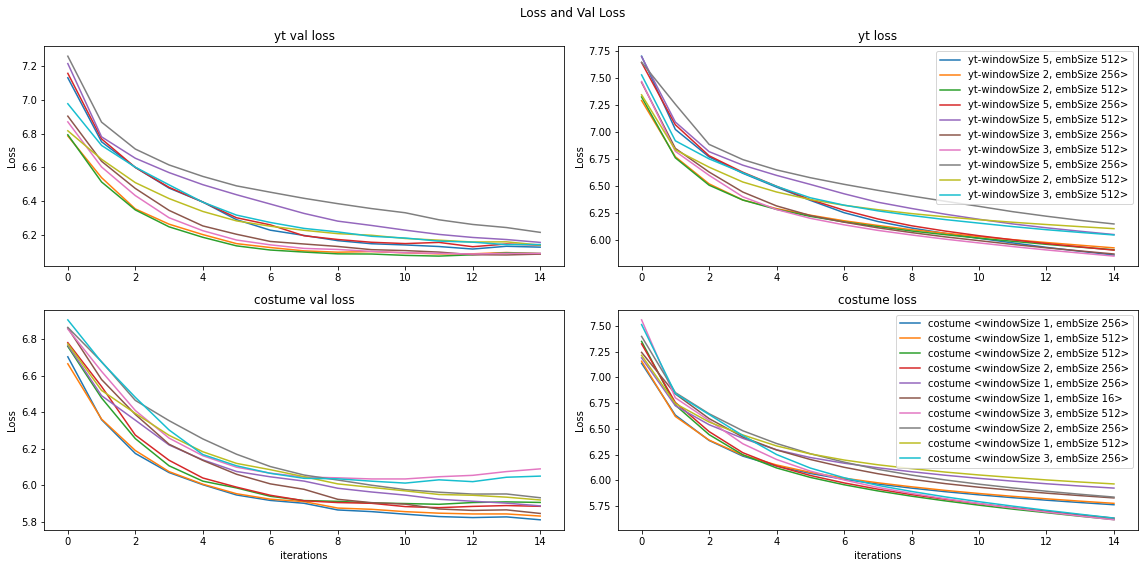

In [13]:
# plot loss and val loss
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
# top 3 by MRR metric yt model
for i, row in yt_df.sort_values(["MRR"], ascending=False).head(top_k).iterrows():
    ax[0, 0].plot(row.val_loss_history, label=f"yt-windowSize {row.window_size}, embSize {row.emb_dims}>")
    ax[0, 1].plot(row.loss_history, label=f"yt-windowSize {row.window_size}, embSize {row.emb_dims}>")
    ax[0, 0].set_ylabel("Loss")
    ax[0, 1].set_ylabel("Loss")
    ax[0, 0].title.set_text('yt val loss')
    ax[0, 1].title.set_text('yt loss')

# top 3 by MRR metric costume
for i, row in costume_df.sort_values(["MRR"], ascending=False).head(top_k).iterrows():
    ax[1, 0].plot(row.val_loss_history, label=f"costume <windowSize {row.window_size}, embSize {row.emb_dims}>")
    ax[1, 1].plot(row.loss_history, label=f"costume <windowSize {row.window_size}, embSize {row.emb_dims}>")
    ax[1, 0].set_xlabel("iterations")
    ax[1, 1].set_xlabel("iterations")
    ax[1, 0].set_ylabel("Loss")
    ax[1, 1].set_ylabel("Loss")
    ax[1, 0].title.set_text('costume val loss')
    ax[1, 1].title.set_text('costume loss')
plt.suptitle("Loss and Val Loss")
ax[0, 1].legend()
ax[1, 1].legend()
plt.tight_layout()
plt.show()

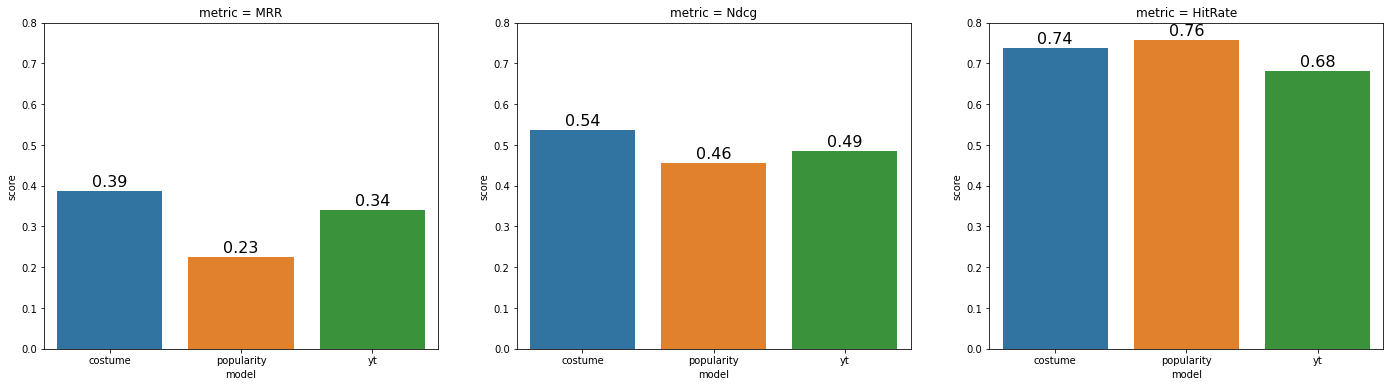

In [14]:
# bar plot best results

metrics = ["MRR", "Ndcg", "HitRate"]
df_temp = pd.DataFrame(columns=["model", "metric", "score"])

for i, row in df_results.iterrows():
    for metric in metrics:
        df_temp = df_temp.append(pd.Series({"model": row.model, "metric": metric, "score": row[metric]}), ignore_index=True)

fig, axs = plt.subplots(1, 3, figsize=(24, 6))
for i, metric in enumerate(metrics):
    df_ = df_temp.drop(df_temp[df_temp.metric != metric].index, inplace=False)
    df_ = df_.groupby(['model']).agg(score=("score", 'max'))
    df_ = df_.reset_index()
    sns.barplot(data=df_, x="model", y="score", ax=axs[i])
    axs[i].set_title(f"metric = {metric}")
    axs[i].set_ylim(0, .8)
    for p in axs[i].patches:
        axs[i].annotate(format(p.get_height(), '.2f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 9),
                        textcoords='offset points',
                        fontsize=16)
plt.show()

**Example model and its prediction for a certain training sample**

In [15]:
window_size = 3
file_name = f"data_{window_size}.csv" if os.path.isfile(f"data/data_{window_size}.csv") else ""
dataset = MovieLensDataset(dir_name="data", max_lockup_history=window_size,
                           file_name=file_name)

load dataset file from disk...


In [46]:
(x_train_c, y_train_c), (x_val_c, y_val_c) = dataset.get_data_for_training_costume()
costum_model = YTDNNCostum(n_classes=dataset.n_movies,
                            n_genres=dataset.n_genres,
                            n_occupation=dataset.n_occupations,
                            n_users=dataset.n_users, emb_dim=emb_dim,
                            dns_dim=dns_dim, k=top_k, lr=lr)

costum_history = costum_model.fit(x=x_train_c, y=y_train_c, epochs=epochs,
                                  batch_size=batch_size, verbose=1,
                                  validation_data=(x_val_c, y_val_c))

Epoch 1/15
313/313 [==============================] - 11s 33ms/step - loss: 7.5346 - acc: 0.0049 - top_10_accuracy: 0.0418 - val_loss: 6.8393 - val_acc: 0.0088 - val_top_10_accuracy: 0.0747
Epoch 2/15
313/313 [==============================] - 9s 28ms/step - loss: 6.7896 - acc: 0.0104 - top_10_accuracy: 0.0800 - val_loss: 6.6090 - val_acc: 0.0142 - val_top_10_accuracy: 0.1041
Epoch 3/15
313/313 [==============================] - 9s 28ms/step - loss: 6.5662 - acc: 0.0136 - top_10_accuracy: 0.1054 - val_loss: 6.3961 - val_acc: 0.0154 - val_top_10_accuracy: 0.1384
Epoch 4/15
313/313 [==============================] - 9s 29ms/step - loss: 6.3431 - acc: 0.0182 - top_10_accuracy: 0.1362 - val_loss: 6.2486 - val_acc: 0.0222 - val_top_10_accuracy: 0.1614
Epoch 5/15
313/313 [==============================] - 9s 28ms/step - loss: 6.1878 - acc: 0.0222 - top_10_accuracy: 0.1559 - val_loss: 6.1459 - val_acc: 0.0265 - val_top_10_accuracy: 0.1848
Epoch 6/15
313/313 [==============================] - 

**Example of top 10 predictions for training sample from validation set that its target is *Star Wars: Episode V - The Empire Strikes Back (1980)***

In [16]:
(x_train_c, y_train_c), (x_val_c, y_val_c) = dataset.get_data_for_training_costume()

In [147]:
star_wars_id = 1178

print(dataset.movies.loc[star_wars_id].title)
samples = []
for x in x_val_c:
  featre = []
  for i in np.where(y_val_c == star_wars_id)[0]:
    featre.append(x[i])
  samples.append(np.array(featre))
predictions = costum_model.call(samples)
print("history:")
for i in samples[0][2]:
  print(dataset.movies.loc[i].title)
top_predictions = tf.argsort(costum_model.call(samples), axis=1, direction="DESCENDING").numpy()[2, :10]

print("\nrecomendations:")
for i in top_predictions:
  print(dataset.movies.loc[i].title)

Star Wars: Episode V - The Empire Strikes Back (1980)
history:
Night on Earth (1991)
Turtle Diary (1985)
Gang Related (1997)

recomendations:
It's a Wonderful Life (1946)
2001: A Space Odyssey (1968)
Felicia's Journey (1999)
House Party 2 (1991)
Fried Green Tomatoes (1991)
Permanent Midnight (1998)
Choices (1981)
Star Wars: Episode V - The Empire Strikes Back (1980)
Die Hard: With a Vengeance (1995)
Niagara, Niagara (1997)


*target*:

* [Star Wars: Episode V - The Empire Strikes Back](https://www.imdb.com/title/tt0080684/?ref_=fn_al_tt_1) geners:[Actions, Adventure, Fantasy]

some of the predictions:

* [2001: A Space Odyssey
](https://www.imdb.com/title/tt0062622/?ref_=fn_al_tt_1) geners: [Adventure, Sci-Fi]
* [Die Hard with a Vengeance](https://www.imdb.com/title/tt0112864/?ref_=fn_al_tt_1)  geners: [Actions, Adventure, Thriller]
* [Felicia's Journey](https://www.imdb.com/title/tt0165773/?ref_=fn_al_tt_1) genres: [Drama, Thriller] 